In [1]:
import pandas as pd
from uwv.config import KNMI_PROCESSED_DATA_DIR, KNMI_AVG_TEMP, CBS_OPENDATA_PROCESSED_DATA_DIR, CBS80072NED
import plotly.graph_objects as go

2024-10-23 09:41:36.583 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [2]:
# Load your existing data (CBS sick leave and KNMI average temperature)
slp = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")
knmi = pd.read_parquet(KNMI_PROCESSED_DATA_DIR / f"{KNMI_AVG_TEMP}.parquet")

In [22]:
# Merge the datasets on 'period_year' and 'period_quarter_number'
sk = pd.merge(slp, knmi, on=['period_year', 'period_quarter_number'], how="inner")

In [24]:
# Load the gender ratio data from the updated CSV (adjust the file path to your CSV file)
file_path = 'c:/Users/c.hakker/OneDrive - VISTA college/Senior Stuff/Opleiding Data science/Back up UWV/Arbeidsvolume__bedrijfstak__geslacht.csv'
gender_data = pd.read_csv(file_path, delimiter=';')

In [28]:
# Filter data for 'Mannen' (Men) and 'Vrouwen' (Women)
male_data = gender_data[gender_data['Geslacht'] == 'Mannen'].copy()
female_data = gender_data[gender_data['Geslacht'] == 'Vrouwen'].copy()

In [30]:
# Convert 'Perioden' to string before extracting the year
male_data['Perioden'] = male_data['Perioden'].astype(str)
female_data['Perioden'] = female_data['Perioden'].astype(str)

In [31]:
# Extract relevant columns and clean the 'Perioden' for year
male_data['period_year'] = male_data['Perioden'].str.extract(r'(\d{4})').astype(int)
female_data['period_year'] = female_data['Perioden'].str.extract(r'(\d{4})').astype(int)

In [32]:
# Select the industry, year, and employment data
male_data = male_data[['Bedrijfstakken/branches (SBI 2008)', 'period_year', 'Werkzame personen (x 1 000)']].rename(columns={
    'Werkzame personen (x 1 000)': 'employed_male'
})
female_data = female_data[['Bedrijfstakken/branches (SBI 2008)', 'period_year', 'Werkzame personen (x 1 000)']].rename(columns={
    'Werkzame personen (x 1 000)': 'employed_female'
})

In [33]:
# Merge male and female data on industry and year to calculate the ratio
gender_ratio = pd.merge(male_data, female_data, on=['Bedrijfstakken/branches (SBI 2008)', 'period_year'])
gender_ratio['male_female_ratio'] = gender_ratio['employed_male'] / gender_ratio['employed_female']

In [34]:
# Now you can proceed with expanding the data to quarters and merging with your sick leave data
# Assuming your sick leave data is already loaded as 'sk'
gender_ratio['period_quarter_number'] = 1  # Start with Q1
gender_ratio_quarters = pd.concat([gender_ratio.assign(period_quarter_number=i) for i in range(1, 5)])

In [35]:
# Merge gender ratio data with sick leave data on year, quarter, and industry
merged_data = pd.merge(
    sk, 
    gender_ratio_quarters, 
    left_on=['period_year', 'period_quarter_number', 'sbi_title'], 
    right_on=['period_year', 'period_quarter_number', 'Bedrijfstakken/branches (SBI 2008)'], 
    how='left'
)

In [36]:
# Example: Calculate Pearson correlation between sick leave percentage and the male/female ratio
correlation_ratio = merged_data['sick_leave_percentage'].corr(merged_data['male_female_ratio'])
print(f"Pearson correlation between Sick Leave Percentage and Male/Female Ratio: {correlation_ratio}")

Pearson correlation between Sick Leave Percentage and Male/Female Ratio: 0.0671442097931799


In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [38]:
# Prepare the data (sick leave percentage and male/female ratio)
X = merged_data[['male_female_ratio']]  # Independent variable (reshape if necessary)
y = merged_data['sick_leave_percentage']  # Dependent variable

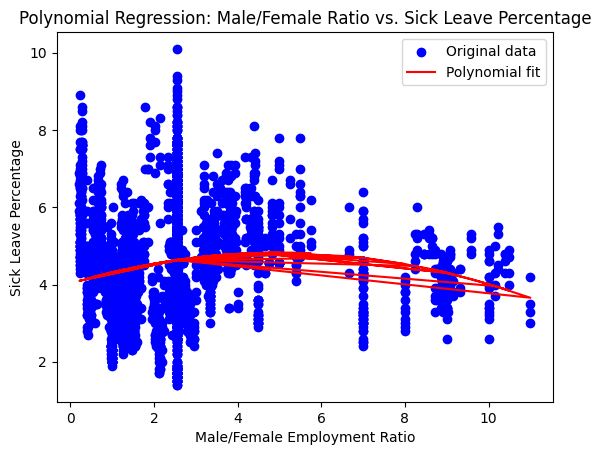

R-squared value for polynomial regression: 0.02093102490622578


In [56]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assume X and y are already defined (X: male_female_ratio, y: sick_leave_percentage)

# Impute missing values in both X and y
imputer = SimpleImputer(strategy='mean')

# Impute X and y for missing values
X_imputed = imputer.fit_transform(X)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Create polynomial features (degree 2 for quadratic relationship)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_imputed)

# Fit the polynomial regression model using the imputed y
model = LinearRegression()
model.fit(X_poly, y_imputed)

# Predict using the polynomial model
y_poly_pred = model.predict(X_poly)

# Plot the original data and the polynomial fit
plt.scatter(X_imputed, y_imputed, color='blue', label='Original data')
plt.plot(X_imputed, y_poly_pred, color='red', label='Polynomial fit')
plt.title('Polynomial Regression: Male/Female Ratio vs. Sick Leave Percentage')
plt.xlabel('Male/Female Employment Ratio')
plt.ylabel('Sick Leave Percentage')
plt.legend()
plt.show()

# Calculate the R-squared value to assess fit
r_squared = model.score(X_poly, y_imputed)
print(f"R-squared value for polynomial regression: {r_squared}")
